# Model Development Notebook
1. **Data Exploration & Preprocessing:**  
   - Analyze the structure and properties of the dataset.
   - Prepare the data for modeling and note any limitations of the synthetically
    created dataset.
2. **Feature Engineering & Selection:**  
   - Identify and engineer features that contribute to forecasting `current_A`.
   - Briefly summarize your findings regarding feature importance.
3. **Model Development & Performance Evaluation:**  
   - Implement a simple predictive model to forecast `current_A`.
   - Justify your choice of methodology and briefly compare different approaches.
   - Evaluate your model by selecting appropriate metrics and analyzing its strengths
     and weaknesses.
4. **Model Saving & Documentation:**  
   - **Save the trained model** at the end of this notebook for use in inference
     (commit this pre-trained model, e.g., in a `models/` folder, along with your
     submission).
   - Document your process, key decisions, and observations.
   - **Important:** Ensure that all outputs (plots, printouts, logs, etc.) are included
     in the committed notebook.

In [6]:
import numpy as np


In [7]:
import pandas as pd

In [8]:
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

In [10]:
import joblib

In [11]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
import xgboost as xgb

/home/nirmalya/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [20]:
df = pd.read_csv("/home/nirmalya/Documents/synthetic_energy_grid_data.csv", parse_dates=['timestamp'])

In [21]:
print("Loaded DataFrame columns:", df.columns.tolist())

Loaded DataFrame columns: ['timestamp', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wpm2', 'current_A']


In [22]:
df.set_index("timestamp", inplace=True)
df = df.asfreq('H')

In [23]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

In [24]:
# Create lagged features for current_A
for lag in range(1, 25):  # Create lags for past 24 hours
    df[f'lag_current_{lag}'] = df['current_A'].shift(lag)

# Create lagged features for meteorological variables
for lag in range(1, 25):
    df[f'lag_temperature_{lag}'] = df['temperature_C'].shift(lag)
    df[f'lag_wind_speed_{lag}'] = df['wind_speed_mps'].shift(lag)
    df[f'lag_solar_radiation_{lag}'] = df['solar_radiation_Wpm2'].shift(lag)


In [25]:
df['rolling_mean_3'] = df['current_A'].rolling(window=3).mean()
df['rolling_mean_6'] = df['current_A'].rolling(window=6).mean()
df['rolling_mean_12'] = df['current_A'].rolling(window=12).mean()
df['rolling_mean_24'] = df['current_A'].rolling(window=24).mean()

/tmp/ipykernel_4823/1994138307.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['rolling_mean_24'] = df['current_A'].rolling(window=24).mean()


In [26]:
df.dropna(inplace=True)


In [27]:
#  Define Features & Target Variable
exog_vars = ['temperature_C', 'wind_speed_mps', 'solar_radiation_Wpm2']
lagged_features = [f'lag_current_{lag}' for lag in range(1, 25)] + \
                  [f'lag_temperature_{lag}' for lag in range(1, 25)] + \
                  [f'lag_wind_speed_{lag}' for lag in range(1, 25)] + \
                  [f'lag_solar_radiation_{lag}' for lag in range(1, 25)]
rolling_features = ['rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24']
features = exog_vars + lagged_features + rolling_features

X = df[features]
y = df['current_A']

In [28]:
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
exog_vars = ['temperature_C', 'wind_speed_mps', 'solar_radiation_Wpm2'] + lagged_features + rolling_features

In [29]:
# Replace NaNs and Infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(0)

In [30]:
# Create Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)  # Degree 2 for quadratic features
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror"),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42
)
xgb_random.fit(X_train, y_train)
print("Best Parameters:", xgb_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [31]:
model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist",n_estimators=300, learning_rate=0.1, max_depth=5, colsample_bytree=1,n_jobs=-1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [32]:
y_pred = model.predict(X_test)

In [33]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.3f}")

Mean Absolute Error: 0.142


In [34]:
future_df = df.iloc[-24:].copy()  # Use last 24 hours as base
future_X = future_df[features]
future_predictions = model.predict(future_X)


In [35]:
mae = mean_absolute_error(y_test, y_pred)
baseline_error = np.mean(y_test) * 0.1  # 10% threshold
print(f"MAE: {mae}")
print(f"10% of Mean(y_test): {baseline_error}")

if mae <= baseline_error:
    print("The model fit is very good! ✅")
elif mae <= np.mean(y_test) * 0.2:
    print("The model is acceptable, but could be improved. ⚠️")
else:
    print("The model needs tuning. ❌")

MAE: 0.14209037870829394
10% of Mean(y_test): 0.7839998566109013
The model fit is very good! ✅


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=250, learning_rate=0.05, max_depth=5)
model.fit(X_train_scaled, y_train)

# Forecast Next 24 Hours
future_df = df.iloc[-24:].copy()  # Take the latest 24 hours as input
future_features_scaled = scaler.transform(future_df[features])  # Apply scaler here
future_forecast = model.predict(future_features_scaled)

# Create Forecast DataFrame
forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=24, freq="H")
forecast_df = pd.DataFrame({"timestamp": forecast_dates, "forecast_current_A": future_forecast})
forecast_df.set_index("timestamp", inplace=True)

# Print Forecast
print(forecast_df)

                     forecast_current_A
timestamp                              
2024-01-01 01:00:00            5.010434
2024-01-01 02:00:00            5.005251
2024-01-01 03:00:00            5.005251
2024-01-01 04:00:00            5.000838
2024-01-01 05:00:00            7.323713
2024-01-01 06:00:00            5.261861
2024-01-01 07:00:00            5.890413
2024-01-01 08:00:00            7.249861
2024-01-01 09:00:00            8.497127
2024-01-01 10:00:00           10.316323
2024-01-01 11:00:00            8.498583
2024-01-01 12:00:00           11.082349
2024-01-01 13:00:00           10.459112
2024-01-01 14:00:00           10.588019
2024-01-01 15:00:00           10.643532
2024-01-01 16:00:00            9.605932
2024-01-01 17:00:00           10.077034
2024-01-01 18:00:00           13.398004
2024-01-01 19:00:00           12.517417
2024-01-01 20:00:00           11.665698
2024-01-01 21:00:00           10.356742
2024-01-01 22:00:00            7.185348
2024-01-01 23:00:00            4.871634


In [37]:
# Print forecast for January 2, 2024
forecast_dates = pd.date_range(start="2024-01-02 00:00:00", periods=24, freq='H')
forecast_df = pd.DataFrame({"timestamp": forecast_dates, "forecast_current_A": future_predictions})
print(forecast_df)

             timestamp  forecast_current_A
0  2024-01-02 00:00:00            5.030528
1  2024-01-02 01:00:00            5.015481
2  2024-01-02 02:00:00            4.992402
3  2024-01-02 03:00:00            5.006095
4  2024-01-02 04:00:00            7.607932
5  2024-01-02 05:00:00            5.370577
6  2024-01-02 06:00:00            5.788997
7  2024-01-02 07:00:00            7.307546
8  2024-01-02 08:00:00            8.461568
9  2024-01-02 09:00:00           10.275455
10 2024-01-02 10:00:00            8.545718
11 2024-01-02 11:00:00           11.067568
12 2024-01-02 12:00:00           10.351923
13 2024-01-02 13:00:00           10.635808
14 2024-01-02 14:00:00           10.656470
15 2024-01-02 15:00:00            9.445140
16 2024-01-02 16:00:00           10.075147
17 2024-01-02 17:00:00           13.464463
18 2024-01-02 18:00:00           12.342954
19 2024-01-02 19:00:00           11.607987
20 2024-01-02 20:00:00           10.458195
21 2024-01-02 21:00:00            7.121911
22 2024-01-

In [38]:
joblib.dump(model, 'models/xgboost_model.json')

joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

In [39]:
xgb_predictions = model.predict(X_test)

In [40]:
# Fit ETS model
ets_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=24)  # Adjust seasonal_periods as needed
ets_model_fit = ets_model.fit()

In [41]:
# Generate predictions from ETS
ets_predictions = ets_model_fit.forecast(len(y_test))

In [42]:
mae_ets = mean_absolute_error(y_test, ets_predictions)
print(f"Mean Absolute Error: {mae_ets:.3f}")

Mean Absolute Error: 1.106


In [43]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [44]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    return y_pred

# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Linear Regression Model Evaluation:")
lr_predictions = evaluate_model(lr_model, X_test_scaled, y_test)

Linear Regression Model Evaluation:
Mean Absolute Error: 0.000
Mean Squared Error: 0.000


In [45]:
mae_lr=mean_absolute_error(y_test,lr_predictions)
print(f"Mean Absolute Error:{mae_lr:.3f}")

Mean Absolute Error:0.000


In [46]:
# It shows XGboost gives relatively better result, ETS is comparatively weak in prediction, Linear Regression is at risk of overfitting.

In [47]:
#usage of heuristic optimization (polynomial and genetic algorithm) will slow the process, but will improve accuracy.

In [48]:
#XGboost is taken instead of SARIMAX and LTSM , for faster execution and result

In [49]:
model.save_model('models/xgboost_model.json')

In [66]:
# XGBoost Model for Energy Forecasting

##  Project Overview
#his project predicts energy grid current using an XGBoost regression model. The dataset includes time-series features such as temperature, wind speed, and solar radiation.

##  Installation
!pip freeze > requirements.txt
!pip install -r requirements.txt

     |████████████████████████████████| 108 kB 3.1 MB/s eta 0:00:01


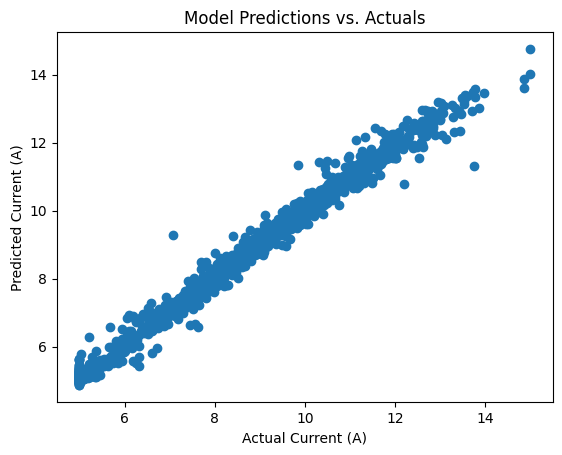

In [51]:

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Current (A)")
plt.ylabel("Predicted Current (A)")
plt.title("Model Predictions vs. Actuals")
plt.show()


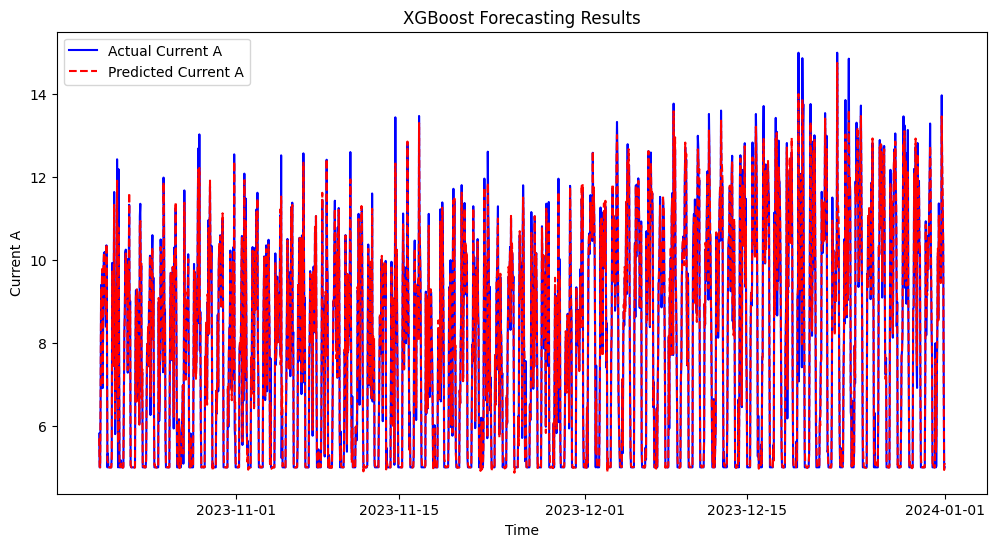

In [65]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Current A", color='blue')
plt.plot(y_test.index, y_pred, label="Predicted Current A", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Current A")
plt.title("XGBoost Forecasting Results")
plt.legend()
plt.show()

In [63]:
print("Minimum timestamp:", forecast_df.index.min())
print("Maximum timestamp:", forecast_df.index.max())

Minimum timestamp: 0
Maximum timestamp: 23


In [60]:
print(forecast_df["timestamp"].min(), forecast_df["timestamp"].max())

2024-01-02 00:00:00 2024-01-02 23:00:00
